In [1]:
!pip install tiktoken datasets wandb -q

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math


In [3]:
from datasets import load_dataset

# Load only a small slice first
ds = load_dataset("ccdv/arxiv-summarization", split="train[:500000]")
print(f"Loaded: {len(ds)} papers")
print(f"Keys: {ds[0].keys()}")
print(f"\nSample abstract:\n{ds[0]['abstract'][:500]}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

section/train-00000-of-00015.parquet:   0%|          | 0.00/230M [00:00<?, ?B/s]

section/train-00001-of-00015.parquet:   0%|          | 0.00/228M [00:00<?, ?B/s]

section/train-00002-of-00015.parquet:   0%|          | 0.00/228M [00:00<?, ?B/s]

section/train-00003-of-00015.parquet:   0%|          | 0.00/227M [00:00<?, ?B/s]

section/train-00004-of-00015.parquet:   0%|          | 0.00/226M [00:00<?, ?B/s]

section/train-00005-of-00015.parquet:   0%|          | 0.00/227M [00:00<?, ?B/s]

section/train-00006-of-00015.parquet:   0%|          | 0.00/229M [00:00<?, ?B/s]

section/train-00007-of-00015.parquet:   0%|          | 0.00/230M [00:00<?, ?B/s]

section/train-00008-of-00015.parquet:   0%|          | 0.00/230M [00:00<?, ?B/s]

section/train-00009-of-00015.parquet:   0%|          | 0.00/228M [00:00<?, ?B/s]

section/train-00010-of-00015.parquet:   0%|          | 0.00/229M [00:00<?, ?B/s]

section/train-00011-of-00015.parquet:   0%|          | 0.00/231M [00:00<?, ?B/s]

section/train-00012-of-00015.parquet:   0%|          | 0.00/230M [00:00<?, ?B/s]

section/train-00013-of-00015.parquet:   0%|          | 0.00/230M [00:00<?, ?B/s]

section/train-00014-of-00015.parquet:   0%|          | 0.00/235M [00:00<?, ?B/s]

section/validation-00000-of-00001.parque(…):   0%|          | 0.00/105M [00:00<?, ?B/s]

section/test-00000-of-00001.parquet:   0%|          | 0.00/105M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/203037 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6436 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6440 [00:00<?, ? examples/s]

Loaded: 203037 papers
Keys: dict_keys(['article', 'abstract'])

Sample abstract:
additive models play an important role in semiparametric statistics . 
 this paper gives learning rates for regularized kernel based methods for additive models . 
 these learning rates compare favourably in particular in high dimensions to recent results on optimal learning rates for purely nonparametric regularized kernel based quantile regression using the gaussian radial basis function kernel , provided the assumption of an additive model is valid . 
 additionally , a concrete example is pre


In [4]:
# Filter for robotics and ML papers
keywords = ['robot', 'manipulation', 'reinforcement learning', 
            'policy', 'control', 'autonomous', 'transformer',
            'neural', 'perception', 'planning']

robotics_abstracts = []
for paper in ds:
    abstract = paper['abstract'].lower()
    if any(kw in abstract for kw in keywords):
        robotics_abstracts.append(paper['abstract'].strip())

print(f"Robotics/ML papers found: {len(robotics_abstracts)}")
print(f"\nSample 1:\n{robotics_abstracts[0][:300]}")
print(f"\nSample 2:\n{robotics_abstracts[1][:300]}")

Robotics/ML papers found: 12664

Sample 1:
we report on strong enhancement of mid - infrared second harmonic generation ( shg ) from sic nanopillars due to the resonant excitation of localized surface phonon - polaritons within the reststrahlen band . 
 the magnitude of the shg peak at the monopole mode experiences a strong dependence on the

Sample 2:
synaptic memory is considered to be the main element responsible for learning and cognition in humans . 
 although traditionally non - volatile long - term plasticity changes have been implemented in nanoelectronic synapses for neuromorphic applications , recent studies in neuroscience have revealed


In [5]:
full_text = "\n\n".join(robotics_abstracts)
print(f"Total characters: {len(full_text):,}")
print(f"Estimated tokens: {len(full_text)//4:,}")

with open('robotics_corpus.txt', 'w') as f:
    f.write(full_text)
    
print("Saved!")

Total characters: 66,391,959
Estimated tokens: 16,597,989
Saved!


## Tokeniser 

In [6]:
import tiktoken
enc = tiktoken.get_encoding("gpt2")

In [7]:
tokens = enc.encode(robotics_abstracts[0])
print(f"Sample abstract:{len(tokens)} tokens")
print(f"Vocab size: {enc.n_vocab}")

Sample abstract:3820 tokens
Vocab size: 50257


In [8]:
import torch

print("Encoding Whole Corpus ")
all_tokens  = enc.encode(full_text)

data = torch.tensor(all_tokens, dtype=torch.long)
print(f"Tensor shape: {data.shape}")

Encoding Whole Corpus 
Tensor shape: torch.Size([16264962])


In [9]:
vocab_size = enc.n_vocab  
block_size = 128
batch_size = 32
d_model = 128
n_heads = 4
n_layers = 4
dropout = 0.1


In [10]:
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]
print(f"Train: {len(train_data):,} tokens")
print(f"Val:   {len(val_data):,} tokens")

Train: 14,638,465 tokens
Val:   1,626,497 tokens


## Model


In [24]:

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        assert d_model % n_heads == 0
        self.n_heads = n_heads
        self.d_k = d_model // n_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
        
    def split_head(self, x , B , T):
            split = x.view(B, T , self.n_heads , self.d_k).transpose(1 ,2)
            return split
        
        
    def merge_heads(self , x , B , T ,C):
            return x.transpose(1,2).contiguous().view(B, T, C)
        
        
        
    def forward(self, x):
            B ,T , C = x.shape
            
            
            Q = self.split_head(self.W_q(x) , B ,T)
            K = self.split_head(self.W_k(x) , B ,T)
            V = self.split_head(self.W_v(x) , B ,T)
            
            
            scores = Q @ K.transpose(-2, -1)          # (B, h, T, T)
            scores = scores / math.sqrt(self.d_k)
            mask = torch.triu(torch.ones(T, T, device=x.device), diagonal=1).bool()
            scores = scores.masked_fill(mask, float('-inf'))
            attn = F.softmax(scores, dim=-1)
            
            
            
            out = attn @ V                           
            out = self.merge_heads(out, B, T, C)      

            return self.W_o(out)


In [12]:

class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, n_heads)
        self.dropout = nn.Dropout(0.1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        

        self.ffn = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.ReLU(),
            nn.Linear(4 * d_model, d_model),
        )

    def forward(self, x):
        x = x + self.dropout(self.attn(self.norm1(x)))
        x = x + self.dropout(self.ffn(self.norm2(x)))
        return x

In [25]:

class TinyTransformer(nn.Module):
    def __init__(self,vocab_size ,d_model , n_heads , max_seq_len , n_layers=2 ) -> None:
        super().__init__()
        
        
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_embedding = nn.Embedding(max_seq_len, d_model)
        # self.block1 = TransformerBlock(d_model, n_heads)
        # self.block2 = TransformerBlock(d_model, n_heads)
        self.head = nn.Linear(d_model, vocab_size)
        self.blocks = nn.ModuleList([TransformerBlock(d_model, n_heads) for _ in range(n_layers)])
        
        
    def forward(self, x):
        B, T = x.shape
        positions = torch.arange(T, device=x.device)
        
        x = self.embedding(x) + self.pos_embedding(positions)
        for block in self.blocks:
            x = block(x)
            
        x = self.head(x)        
        return x

In [26]:
model = TinyTransformer(
    vocab_size=vocab_size,
    d_model=d_model,
    n_heads=n_heads,
    max_seq_len=block_size,
    n_layers=n_layers
)

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
print(f"Device: {device}")

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

Device: cuda
Total parameters: 13,725,521


## Training Loop

In [28]:
def get_batch(data):
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix]).to(device)
    y = torch.stack([data[i+1:i+block_size+1] for i in ix]).to(device)
    return x, y

In [29]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.1)


In [38]:
warmup_steps = 100
max_steps = 30000

In [39]:
def get_lr(step):
    if step < warmup_steps:
        return step / warmup_steps 
    progress = (step - warmup_steps) / (max_steps - warmup_steps)
    return 0.5 * (1 + math.cos(math.pi * progress)) 

In [32]:
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, get_lr)

In [33]:
loss_fn = nn.CrossEntropyLoss()

In [34]:
import math

losses = []
model.train()

TinyTransformer(
  (embedding): Embedding(50257, 128)
  (pos_embedding): Embedding(128, 128)
  (head): Linear(in_features=128, out_features=50257, bias=True)
  (blocks): ModuleList(
    (0-3): 4 x TransformerBlock(
      (attn): MultiHeadAttention(
        (W_q): Linear(in_features=128, out_features=128, bias=True)
        (W_k): Linear(in_features=128, out_features=128, bias=True)
        (W_v): Linear(in_features=128, out_features=128, bias=True)
        (W_o): Linear(in_features=128, out_features=128, bias=True)
      )
      (dropout): Dropout(p=0.1, inplace=False)
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ffn): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=128, bias=True)
      )
    )
  )
)

In [40]:
for step in range(max_steps):
    x, y = get_batch(train_data)
    logits = model(x)
    loss = loss_fn(logits.transpose(1, 2), y)
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    
    optimizer.step()
    scheduler.step()
    
    losses.append(loss.item())
    
    if step % 100 == 0:
        lr = scheduler.get_last_lr()[0]
        print(f"step {step:4d} | loss {loss.item():.4f} | lr {lr:.6f}")
    
    if step % 500 == 0 and step > 0:
        checkpoint = {
            'step': step,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'loss': loss.item(),
            'config': {
                'vocab_size': vocab_size,
                'd_model': d_model,
                'n_heads': n_heads,
                'n_layers': n_layers,
                'block_size': block_size,
            }
        }
        torch.save(checkpoint, f'robotics_gpt_step{step}.pt')
        print(f"  → Checkpoint saved: robotics_gpt_step{step}.pt")

final_checkpoint = {
    'step': max_steps,
    'model_state': model.state_dict(),
    'optimizer_state': optimizer.state_dict(),
    'loss': losses[-1] if losses else None,
    'config': {
        'vocab_size': vocab_size,
        'd_model': d_model,
        'n_heads': n_heads,
        'n_layers': n_layers,
        'block_size': block_size,
    }
}
torch.save(final_checkpoint, 'robotics_gpt_final.pt')
print("Final model saved!")
print("Done!")


step    0 | loss 4.3229 | lr 0.000293
step  100 | loss 4.2232 | lr 0.000292
step  200 | loss 4.5816 | lr 0.000292
step  300 | loss 4.3250 | lr 0.000291
step  400 | loss 4.5178 | lr 0.000291
step  500 | loss 4.4010 | lr 0.000290
  → Checkpoint saved: robotics_gpt_step500.pt
step  600 | loss 4.1922 | lr 0.000290
step  700 | loss 4.2426 | lr 0.000289
step  800 | loss 4.3097 | lr 0.000288
step  900 | loss 4.3781 | lr 0.000288
step 1000 | loss 4.3206 | lr 0.000287
  → Checkpoint saved: robotics_gpt_step1000.pt
step 1100 | loss 4.2437 | lr 0.000286
step 1200 | loss 4.3352 | lr 0.000286
step 1300 | loss 4.4064 | lr 0.000285
step 1400 | loss 4.0117 | lr 0.000284
step 1500 | loss 4.1325 | lr 0.000284
  → Checkpoint saved: robotics_gpt_step1500.pt
step 1600 | loss 4.3920 | lr 0.000283
step 1700 | loss 4.4113 | lr 0.000282
step 1800 | loss 4.0190 | lr 0.000282
step 1900 | loss 4.2043 | lr 0.000281
step 2000 | loss 4.0763 | lr 0.000280
  → Checkpoint saved: robotics_gpt_step2000.pt
step 2100 | los

In [43]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Failed to issue request POST https://colab.research.google.com/tun/m/credentials-propagation/gpu-t4-s-34oh5b018j4if?authtype=dfs_ephemeral&version=2&dryrun=false&propagate=true&record=false&authuser=0&authuser=0: Bad Request
Response body: 
<!DOCTYPE html>
<html lang=en>
  <meta charset=utf-8>
  <meta name=viewport content="initial-scale=1, minimum-scale=1, width=device-width">
  <title>Error 400 (Bad Request)!!1</title>
  <style>
    *{margin:0;padding:0}html,code{font:15px/22px arial,sans-serif}html{background:#fff;color:#222;padding:15px}body{margin:7% auto 0;max-width:390px;min-height:180px;padding:30px 0 15px}* > body{background:url(//www.google.com/images/errors/robot.png) 100% 5px no-repeat;padding-right:205px}p{margin:11px 0 22px;overflow:hidden}ins{color:#777;text-decoration:none}a img{border:0}@media screen and (max-width:772px){body{background:none;margin-top:0;max-width:none;padding-right:0}}#logo{background:url(//www.google.com/images/logos/errorpage/error_logo-150x54.png) no-repeat;margin-left:-5px}@media only screen and (min-resolution:192dpi){#logo{background:url(//www.google.com/images/logos/errorpage/error_logo-150x54-2x.png) no-repeat 0% 0%/100% 100%;-moz-border-image:url(//www.google.com/images/logos/errorpage/error_logo-150x54-2x.png) 0}}@media only screen and (-webkit-min-device-pixel-ratio:2){#logo{background:url(//www.google.com/images/logos/errorpage/error_logo-150x54-2x.png) no-repeat;-webkit-background-size:100% 100%}}#logo{display:inline-block;height:54px;width:150px}
  </style>
  <a href=//www.google.com/><span id=logo aria-label=Google></span></a>
  <p><b>400.</b> <ins>That’s an error.</ins>
  <p>  <ins>That’s all we know.</ins>


### Loss

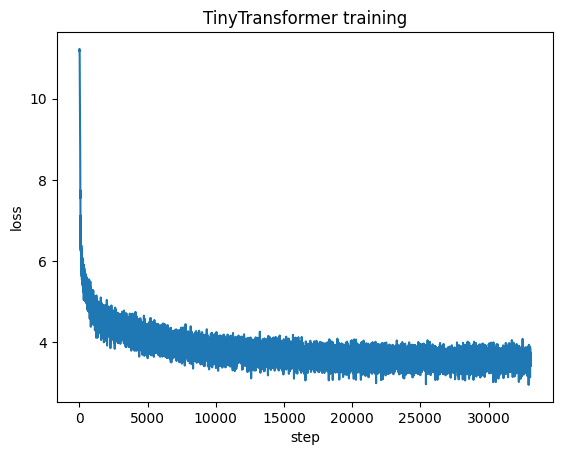

In [42]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel("step")
plt.ylabel("loss")
plt.title("TinyTransformer training")
plt.show()

In [ ]:
import os
print(f"Model saved at: {os.path.abspath('robotics_gpt_final.pt')}")


## Inferance

model.eval()

def generate(prompt, max_new_tokens=200, temperature=0.8):
    tokens = enc.encode(prompt)
    idx = torch.tensor([tokens], dtype=torch.long).to(device)
    
    with torch.no_grad():
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits = model(idx_cond)
            logits = logits[:, -1, :] / temperature
            probs = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, next_token], dim=1)
    
    return enc.decode(idx[0].tolist())

print(generate("We propose a novel approach to robot manipulation using"))
print("---")
print(generate("In this paper we present a transformer-based policy for"))

In [47]:
prompt = """Abstract: We propose a novel method for robot grasping using 
reinforcement learning. Our approach achieves 95% success rate.

Abstract:"""

print(generate(prompt, temperature=0.7))

Abstract: We propose a novel method for robot grasping using 
reinforcement learning. Our approach achieves 95% success rate.

Abstract:0 and their impact in good agreement with the data . 
 a numerical analysis is provided by the results of the results of the framework of the education of the analysis of the physics of the european commission , and the research office for publication .

we present an accurate problem in the framework of the analysis of the model of the annulated classification of the stochastic networks . 
 we present a new model to study the algorithm and find a prior - controlled discrete ( les - synchrony ) solution that is currently accessible to the medium of a few - color layer ( i.e. @xmath0 ) . 
 the nn is the atom - defocusing of the hop - ionized - fermion coupling at the lowest energy , and this feature is further @xcite . 
 using the epsrc at half of the rate of the gas with the center of the nucleon and the dashed line is positive , which is a tight - bin

## Save Model To Drive 

In [45]:
model.eval()

def generate(prompt, max_new_tokens=200, temperature=0.8):
    tokens = enc.encode(prompt)
    idx = torch.tensor([tokens], dtype=torch.long).to(device)
    
    with torch.no_grad():
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits = model(idx_cond)
            logits = logits[:, -1, :] / temperature
            probs = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, next_token], dim=1)
    
    return enc.decode(idx[0].tolist())

print(generate("We propose a novel approach to robot manipulation using"))
print("---")
print(generate("In this paper we present a transformer-based policy for"))

We propose a novel approach to robot manipulation using a coupled line sensing function whose orientation of the network . in the input laser to the node , 
 further , we ask the average time of a narrow bonds , which is presented in our design , as discussed above . 
 furthermore , we assume a number of inputs on a superposition of a single photons in which the nodes can be selected using a classical computer architecture . 
 , we consider an example of the minimal pair of qubit states to produce the maximum entanglement and pair information in the presence of hard - mechanical interactions . 
 the random variable of the quantum qd model is a robust system with a two - body interactions between the time - independent qubit and qubit states . for all qubits 
 , we consider a basis by the hamiltonian @xmath39 and a separate simple coupling between intra qubits . in this , 
 stabilizing the quantum resource of the entanglement entropy on the classical entanglement process , not simply on

In [46]:
import shutil
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Create a folder in Drive to store the model
save_dir = '/content/drive/MyDrive/robotics_gpt'
import os
os.makedirs(save_dir, exist_ok=True)

# Copy the final model checkpoint to Drive
shutil.copy('robotics_gpt_final.pt', f'{save_dir}/robotics_gpt_final.pt')
print(f"Model saved to Google Drive at: {save_dir}/robotics_gpt_final.pt")

# Also copy any periodic checkpoints if they exist
for f in os.listdir('.'):
    if f.startswith('robotics_gpt_step') and f.endswith('.pt'):
        shutil.copy(f, f'{save_dir}/{f}')
        print(f"  → Also saved: {f}")


Mounted at /content/drive
Model saved to Google Drive at: /content/drive/MyDrive/robotics_gpt/robotics_gpt_final.pt
  → Also saved: robotics_gpt_step20500.pt
  → Also saved: robotics_gpt_step21500.pt
  → Also saved: robotics_gpt_step3000.pt
  → Also saved: robotics_gpt_step7500.pt
  → Also saved: robotics_gpt_step2500.pt
  → Also saved: robotics_gpt_step7000.pt
  → Also saved: robotics_gpt_step11500.pt
  → Also saved: robotics_gpt_step1500.pt
  → Also saved: robotics_gpt_step27000.pt
  → Also saved: robotics_gpt_step1000.pt
  → Also saved: robotics_gpt_step23500.pt
  → Also saved: robotics_gpt_step24500.pt
  → Also saved: robotics_gpt_step29000.pt
  → Also saved: robotics_gpt_step22000.pt
  → Also saved: robotics_gpt_step2000.pt
  → Also saved: robotics_gpt_step11000.pt
  → Also saved: robotics_gpt_step5500.pt
  → Also saved: robotics_gpt_step21000.pt
  → Also saved: robotics_gpt_step14000.pt
  → Also saved: robotics_gpt_step24000.pt
  → Also saved: robotics_gpt_step12500.pt
  → Also s